# Práctica 3 - CNN para clasificar imágenes de frutas - Lab 1
## Preparación de entorno
#### Instalar las librerías

In [106]:
# %pip install numpy
# %pip install pandas
# %pip install matplotlib
# %pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu126
# %pip install torchinfo
# %pip install torchview
# %pip install graphviz
# %pip install scikit-learn

#### Importar librerías de código

In [107]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from graphviz import Digraph
from sklearn.model_selection import StratifiedShuffleSplit
from torch.utils.data import DataLoader, Subset
from torchinfo import summary
from torchview import draw_graph
from torchvision import datasets, transforms
import random
from collections import defaultdict

## CNN SetUp
* **Red convolucional secuencial (CNN secuencial)** $\rightarrow$ Tipo de red neuronal convolucional diseñada utilizando un modelo secuenncial (una pila lineal de capas donde cada capa recibe la salida de la capa anterior como entrada).
  * **Convolución** $\rightarrow$ Operación matemática que combina dos funciones para producir una tercera función. En el contexto de las CNN, se utiliza para extraer características de las imágenes.
  * **Capas** $\rightarrow$ Capas de convolución, activación, pooling y completamente conectadas (fully connected).
  * Recibe **varias entradas** (como señales), cada una con un peso que indica su importancia.

* Componentes principales de una CNN secuencial:
  * **Capas convolucionales** $\rightarrow$ Aplican filtros para extraer características relevantes de las imágenes, como bordes, texturas o patrones. El tamaño y número de filtros son hiperparámetros que definimos nosotros.
  * **Funciones de activación** $\rightarrow$ Generalmente, se utiliza *ReLU* para introducir no linealidad en las capas intermedias, mientras que *Softmax* se utiliza en la capa de salida para problemas de clasificación multiclase.
  * **Capas de pooling** $\rightarrow$ Reducen las dimensiones espaciales (alto y ancho) de las características manteniendo las más relevantes. Esto disminuye el coste computacional y nos ayuda a prevenir el sobreajuste.
  * **Capas completamente conectadas** $\rightarrow$ Al final, las características que hemos extraído las aplanamos y las pasamos a una o más capas densas (completamente conectadas) para hacer la clasificación final.
  * **Optimizador y fución de pérdida** $\rightarrow$ Utilizamos *RMSprop* como optimizador y *categorical_crossentropy* como función de pérdida para problemas de clasificación multiclase. Estos son hiperparámetros que podemos ajustar según nuestras necesidades.

<img src="./media/Estructura cnn.jpg" width="70%" style="display: block; margin: 0 auto;"/>

<img src="./media/Arquitectura cnn.jpg" width="70%" style="display: block; margin: 0 auto; padding-top: 15px;"/>

* Aplicaciones de las redes convolucionales:
  * **Clasificación de imágenes** $\rightarrow$ Identificar objetos en imágenes, como en nuestro caso (clasificar frutas).
  * **Detección de objetos** $\rightarrow$ Localizar y clasificar múltiples objetos en una imagen.
  * **Segmentación de imágenes** $\rightarrow$ Dividir una imagen en regiones significativas, como identificar diferentes partes de una imagen médica.
  * **Reconocimiento facial** $\rightarrow$ Identificar y verificar caras en imágenes o videos.
  * **Procesamiento de video** $\rightarrow$ Analizar secuencias temporales como en coches autónomos o vigilancia.
  * **Generación de imágenes** $\rightarrow$ Crear imágenes nuevas a partir de datos existentes, como en el caso de *GANs* (Generative Adversarial Networks).
  * **Reconocimietnto de texto** $\rightarrow$ Extraer texto de imágenes (OCR).
  
### Implementación

Lo primero que vamos a hacer antes de entrenar la red, es preparar adecuadamente los datos. En este caso, vamos a utilizar el dataset de frutas [*"Fruits 360"*](https://www.kaggle.com/datasets/moltean/fruits/data), donde las imágenes están organizadas en carpetas según su clase (es decir, cada carpeta corresponde a una fruta distinta). Esto nos va a ayudar mucho, porque podemos utlizar la función *ImageFolder* de PyTorch, que automáticamente asigna una etiqueta a cada imagen según el nombre de la carpeta en la que se encuentra.

Como las redes neuronales no pueden procesar directamente JPEGs, necesitamos convertirlas a tensores, que son estructuras numéricas similares a matrices. Para ello vamos a usar una serie de transformaciones que aplicarmeros a cada imagen: primero las redimensionamos a un tamaño uniforme (64x64 píxeles), y luego las convertimos a tensores, lo cual también normaliza sus valores de píxel entre 0 y 1. Esto va ayudar a que nuestro modelo entrene de forma más estable.

> **Nota:** Cuanto más grande sea la imagen, más tiempo tardará en entrenar el modelo. En este caso, hemos elegido 64x64 píxeles como un tamaño intermedio que debería funcionar bien para nuestro problema. En general, es recomendable usar imágenes de tamaño uniforme para evitar problemas de memoria y mejorar la eficiencia del entrenamiento. Sin embargo, si tenemos imágenes de diferentes tamaños, podemos usar técnicas de *data augmentation* para aumentar la diversidad del dataset y mejorar la capacidad de generalización del modelo.

In [108]:
# Rutas de los directorios de datos
DIRECTORIO_ENTRENAMIENTO = './data/FandV/Training'
DIRECTORIO_PRUEBAS = './data/FandV/Test'

# Ficheros de datos
FICHERO_INFORMACION_ENTRENAMIENTO_VALIDACION = "./output/FandV/info_entrenamiento_validacion.txt"
FICHERO_PREDICCIONES = "./output/FandV/predicciones_test.txt"
FICHERO_MODELO_1 = "./output/FandV/modelo_1.pth"
FICHERO_MODELO_2 = "./output/FandV/modelo_2.pth"
FICHERO_MODELO_3 = "./output/FandV/modelo_3.pth"

# Transformaciones que vamos a aplicar a las imágenes
transformacion_entrenamiento = transforms.Compose([
    transforms.Resize((64, 64)),                                            # Redimensionamos todas las imágenes al mismo tamaño (64x64)
    transforms.ToTensor(),                                                  # Convertimos la imagen a tensor (valores entre 0 y 1)
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])                  # Normalizamos la imagen (valores entre -1 y 1)
])

transformacion_validacion = transforms.Compose([
    transforms.Resize((64,64)),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

# Cargamos las imágenes usando ImageFolder, que usa la carpeta como etiqueta
dataset_sin_transformar = datasets.ImageFolder(root=DIRECTORIO_ENTRENAMIENTO, transform=transforms.ToTensor())
etiquetas = [etiqueta for _, etiqueta in dataset_sin_transformar]
indices = list(range(len(dataset_sin_transformar)))

# Limpiamos los ficheros de salida para no mezclar los resultados de
# ejecuciones anteriores
with open(FICHERO_INFORMACION_ENTRENAMIENTO_VALIDACION, 'w') as f:
    f.write("")

with open(FICHERO_PREDICCIONES, 'w') as f:
    f.write("")

Una vez que ya hemos cagado todas las imágenes y las tenemos en el tensor, tenemos que dividir el conjunto de datos de `DIRECTORIO_ENTRENAMIENTO` en dos subconjuntos:
* **Conjunto de entrenamiento** $\rightarrow$ Lo vamos a utilizar para entrenar el modelo. Este conjunto tiene la mayoría de las imágenes y es donde el modelo aprende a reconocer patrones y características de las frutas.
* **Conjunto de validación** $\rightarrow$ Lo utilizamos para evaluar el rendimiento del modelo durante el entrenamiento. Este conjunto tiene menos imágenes y se utiliza para comprobar si el modelo está aprendiendo correctamente y no se está sobreajustando a los datos de entrenamiento.

Esta división nos va a permitir entrenar el modelo con una parte de los latos y luego comprobar como de bien generaliza con datos que no ha visto antes. Normalmente, se suele reservar un 20% de los datos para validación. Para dividir el dataset, vamos a utilizar la función `random_split` de PyTorch, que nos permite dividir un dataset en dos subconjuntos de forma aleatoria. Esta función toma como entrada el dataset original y las longitudes de los subconjuntos que queremos crear.

In [109]:
def undersample_indices(dataset):
    indices_por_clase = defaultdict(list)

    for idx, (_, clase) in enumerate(dataset):
        indices_por_clase[clase].append(idx)

    tamanio_minimo = min(len(lst) for lst in indices_por_clase.values())
    print(f"Tamaño mínimo por clase: {tamanio_minimo}")

    indices_balanceados = []
    etiquetas_balanceadas = []

    for clase, lista_indices in indices_por_clase.items():
        recorte = random.sample(lista_indices, tamanio_minimo)
        indices_balanceados.extend(recorte)
        etiquetas_balanceadas.extend([clase] * tamanio_minimo)

    return indices_balanceados, etiquetas_balanceadas

def split_conjunto_estratificado(dataset, indices, etiquetas, train_ratio=0.7, val_ratio=0.15, test_ratio=0.15):
    indices_por_clase = defaultdict(list)

    for idx, clase in zip(indices, etiquetas):
        indices_por_clase[clase].append(idx)

    train_idx, val_idx, test_idx = [], [], []
    for clase, lista_indices in indices_por_clase.items():
        random.shuffle(lista_indices)
        total = len(lista_indices)

        n_train = max(1, int(total * train_ratio))
        n_val   = max(1, int(total * val_ratio))
        n_test  = max(1, int(total * test_ratio))

        # Ajustar si la suma supera el total
        while n_train + n_val + n_test > total:
            if n_train > 1: n_train -= 1
            elif n_val > 1: n_val -= 1
            elif n_test > 1: n_test -= 1
            else: break

        train_idx += lista_indices[:n_train]
        val_idx   += lista_indices[n_train:n_train+n_val]
        test_idx  += lista_indices[n_train+n_val:n_train+n_val+n_test]

    return (
        Subset(dataset, train_idx),
        Subset(dataset, val_idx),
        Subset(dataset, test_idx)
    )


# Aplicamos las transformaciones manualmente a los subsets
# Reasignamos transformaciones individualmente
class DatasetConTransformacion(torch.utils.data.Dataset):
    """Clase para aplicar transformaciones a un subset de datos.
    Esta clase hereda de torch.utils.data.Dataset y nos permite aplicar
    transformaciones a un subset de datos de forma personalizada.

    Args:
        torch.utils.data.Dataset: Clase base para datasets de PyTorch.
    """

    def __init__(self, subset, transform):
        """Inicializa la clase DatasetConTransformacion.
        Esta función se llama al crear una instancia de la clase.

        Args:
            subset: Subset de datos al que se le aplicarán las transformaciones.
            transform: Transformaciones a aplicar a las imágenes.
        """
        self.subset = subset
        self.transform = transform


    def __getitem__(self, index):
        """Devuelve una imagen y su etiqueta del subset.
        Esta función se llama al acceder a un elemento del dataset.

        Args:
            index: Índice del elemento que queremos obtener.

        Returns:
            PIL.Image: Imagen transformada.
        """
        imagen, etiqueta = self.subset[index]
        if isinstance(imagen, torch.Tensor):
            imagen = transforms.ToPILImage()(imagen)
        return self.transform(imagen), etiqueta


    def __len__(self):
        """"Devuelve el número de elementos en el subset.
        Esta función se llama al usar len() en el dataset.

        Returns:
            int: Número de elementos en el subset.
        """
        return len(self.subset)


indices, etiquetas = undersample_indices(dataset_sin_transformar)


subset_entrenamiento, subset_validacion, subset_test = split_conjunto_estratificado(
    dataset_sin_transformar,
    indices,
    etiquetas
)

dataset_entrenamiento = DatasetConTransformacion(subset_entrenamiento, transformacion_entrenamiento)
dataset_validacion = DatasetConTransformacion(subset_validacion, transformacion_validacion)
dataset_pruebas = DatasetConTransformacion(subset_test, transformacion_validacion)

# Usamos DataLoader para cargar los datos en batches
# (shuffle=True significa que mezclamos los datos en cada época)
loader_entrenamiento = DataLoader(dataset_entrenamiento, shuffle=True)
loader_validacion = DataLoader(dataset_validacion, shuffle=False)
loader_pruebas = DataLoader(dataset_pruebas, shuffle=False)

# Número de clases (etiquetas diferentes)
num_clases = len(dataset_sin_transformar.classes)

# Mostramos la información del dataset
print("---------------------------------------------------------------------------------")
print("                             Información del dataset                             ")
print("---------------------------------------------------------------------------------")
print(f"* Directorio de entrenamiento: {DIRECTORIO_ENTRENAMIENTO}")
print(f"* Directorio de pruebas: {DIRECTORIO_PRUEBAS}")
print("\n")
print(f"* Número total de imágenes: {len(dataset_sin_transformar)}")
print(f"* Número de imágenes de entrenamiento: {len(dataset_entrenamiento)}")
print(f"* Número de imágenes de validación: {len(dataset_validacion)}")
print(f"* Dimensiones de las imágenes originales: {dataset_sin_transformar[0][0].shape}")
print(f"* Dimensiones de las imágenes transformadas: {dataset_entrenamiento[0][0].shape}")
print("\n")
print(f"* Número de batches de entrenamiento: {len(loader_entrenamiento)}")
print(f"* Número de batches de validación: {len(loader_validacion)}")
print(f"* Tamaño de cada batch de entrenamiento: {loader_entrenamiento.batch_size}")
print(f"* Tamaño de cada batch de validación: {loader_validacion.batch_size}")
print("\n")
print(f"* Número de clases: {num_clases}")
print(f"* Ejemplo de clases: {dataset_sin_transformar.classes[30:34]}")

Tamaño mínimo por clase: 144
---------------------------------------------------------------------------------
                             Información del dataset                             
---------------------------------------------------------------------------------
* Directorio de entrenamiento: ./data/FandV/Training
* Directorio de pruebas: ./data/FandV/Test


* Número total de imágenes: 92545
* Número de imágenes de entrenamiento: 18000
* Número de imágenes de validación: 3780
* Dimensiones de las imágenes originales: torch.Size([3, 100, 100])
* Dimensiones de las imágenes transformadas: torch.Size([3, 64, 64])


* Número de batches de entrenamiento: 18000
* Número de batches de validación: 3780
* Tamaño de cada batch de entrenamiento: 1
* Tamaño de cada batch de validación: 1


* Número de clases: 180
* Ejemplo de clases: ['Apricot 1', 'Avocado 1', 'Avocado ripe 1', 'Banana 1']


Ahora vamos a construir la arquitectura de la red neuronal que aprenderá a clasificar las frutas a partir de las imágenes que le pasemos. En este caso, vamos a utilizar una red convolucional secuencial (CNN secuencial), que se caracteria por apilar capas una tras otra en orden lineal.

Nuestra red va a tener varias capas convolucionales, al menos tres, para extraer características visuales (como bordes, texturas o formas), seguidas por capas de pooling que reducirán la dimensaionalidad conservando lo más importante. Al final, vamos a aplanar la salida y la pasaremos por una capa densa/completamente conectada que emitirá una probabilidad para cada clase usando softmax. Además, todas las capas ocultas llevarán activación ReLU.

Como funciones de optimización, vamos a utilizar *RMSprop*, que es un optimizador adaptativo que ajusta la tasa de aprendizaje para cada parámetro. Esto nos es útil porque nos ayuda a converger más rápido y evita problemas de oscilación en la función de pérdida. La función de pérdida que vamos a utilizar es *categorical_crossentropy*, que mide la diferencia entre las probabilidades predichas por el modelo y las etiquetas reales. 

> **Nota:** Lo bueno de usar `CrossEntropyLoss()` es que no tenemos que preocuparnos por aplicar softmax en la última capa, ya que esta función lo hace automáticamente (internamente aplica softmax + log loss). 

Como hemos mencionado antes, nuestra arquitectura tiene tres bloques convolucionales: cada uno aplica filtros (pequeñas "ventanas" que extraen patrones visuales) y reduce la resolución con *MaxPooling* (que toma el valor máximo de cada bloque). Nuestra idea es que las primeras capas detecten características simples (como bordes), y las últimas capas detecten características más complejas (como sería la forma de la fruta).

Luego usamos `Flatten()` para convertir la salida 3D a un vector 1D, que se lo pasamos a una capa densa (*Linear*). Añadimos una capa `Dropout()` para prevenir el overfitting, haciendo que nuestro modelo no se quede "demasiado cómodo" con los datos de entrenamiento. Finalmente, usamos una última capa *Linear* con tantas salidas coo clases tenemos.

Para calcular el tamaño que tendrá la salida después de pasar por las capas de `MaxPool2d` hemos hecho el siguiente cálculo: Cada capa de *MaxPooling* con un tamaño de kernel de $2 \times 2$ y un stride (paso) de $2$ reduce las dimensiones de la imagen a la mitad. Por lo tanto, si empezamos con una imagen de $64 \times 64$ tendremos:
* Después del primer *MaxPooling* (64, 64) $\rightarrow$ (32, 32).
* Después del segundo *MaxPooling* (32, 32) $\rightarrow$ (16, 16).
* Después del tercer *MaxPooling* (16, 16) $\rightarrow$ (8, 8).

Así que la salida final antes de aplanar es de $8 \times 8$, con 128 canales (los asignamos nosotros). La salida de esta capa `Flatten()` tiene un tamaño de $8 \times 8 \times 128 = 8192$.

> **Nota:** En la primera capa convolucional, `in_channels` es 3 porque las imágenes tienen 3 canales (RGB). En la última capa, `out_features` es el número de clases que tenemos.
> 
> Si la imagen por ejemplo fuese en blanco y negro (escala de grises), entonces `in_channels` sería 1, porque solo habría un canal.
>
> Cada uno de estos canales, al final, es una matriz 2D que representa la intaensidad del color correspondiente en cada píxel. Juntos forman una imagen 3D con dimensiones $(canales, alto, ancho)$.

In [110]:
class ClasificadorCNN(nn.Module):
    """Clase para definir un clasificador CNN (Red Neuronal Convolucional).
    Esta clase hereda de nn.Module y con ella definimos la arquitectura de
    la red neuronal.

    Args:
        nn (_type_): _description_
    """

    def __init__(self, num_clases, filtros=(32, 64, 128), capa_densa_num_neuronas=256, dropout=0.5):
        """Inicializa la clase ClasificadorCNN.
        Esta función se llama al crear una instancia de la clase.

        Args:
            num_clases (int): Número de clases (etiquetas) diferentes en el dataset.
            filtros (tuple, optional): Filtros de las capas convolucionales. Por defecto son (32, 64, 128).
            capa_densa_num_neuronas (int, optional): Número de neuronas en la capa densa. Por defecto son 256.
            dropout (float, optional): Tasa de dropout. Por defecto es 0.5.
        """

        # Incializamos la clase padre nn.Module
        # para poder usar todas sus funcionalidades
        # (como el método forward, que define cómo seprocesa la entrada)
        super(ClasificadorCNN, self).__init__()

        self.modelo = nn.Sequential(
            # Primera capa convolucional
            nn.Conv2d(in_channels=3, out_channels=filtros[0], kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Segunda capa convolucional
            nn.Conv2d(in_channels=filtros[0], out_channels=filtros[1], kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Tercera capa convolucional
            nn.Conv2d(in_channels=filtros[1], out_channels=filtros[2], kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Aplanamos las dimensiones de la imagen para que
            # se pueda usar en la capa densa (lineal).
            nn.Flatten(),

            # Capa densa (lineal) de salida
            nn.Linear(filtros[2] * 8 * 8, capa_densa_num_neuronas),
            nn.ReLU(),
            nn.Dropout(dropout),

            # Capa de salida (número de clases)
            nn.Linear(capa_densa_num_neuronas, num_clases)
        )


    def forward(self, x):
        """Define cómo se procesa la entrada a través de la red.
        Esta función se llama automáticamente al pasar una entrada a la red.

        Args:
            x: Entrada a la red (tensor de imágenes).

        Returns:
            Salida de la red (tensor de predicciones).
        """
        return self.modelo(x)

Como ya hemos definido la arquitectura de la red, ahora vamos a preparar todo lo que es necesario para entrenarla (el optimizador, la función de pérdida, el número de épocas, etc).

Entrenar un modelo es básicamente ajustar los pesos para que las predicciones se acerquen lo más posible a las etiquetas verdderas. Para hacer esto vamos a necesitar una función de pérdida (mide qué tan mal lo está haciendo), un optimizdor (que actualiza los pesos para reducir la pérdida) y un bucle de entrenamiento donde pasaremos todos los datos varias veces (cada vez es una época).

In [111]:
def entrenar_modelo(num_modelo, modelo, loader_entrenamiento, loader_validacion, num_epocas, learning_rate, nombre_guardado, nombre_guardado_txt="output/FandV/informacion_entrenamiento_validacion.txt"):
    """Entrena un modelo de red neuronal convolucional (CNN) y valida su rendimiento.

    Args:
        num_modelo: Número del modelo (para guardar el modelo y los resultados).
        modelo: Modelo de red neuronal convolucional (CNN) a entrenar.
        loader_entrenamiento: DataLoader para el conjunto de entrenamiento.
        loader_validacion: DataLoader para el conjunto de validación.
        num_epocas: Número de épocas para el entrenamiento.
        learning_rate: Learning rate para el optimizador.
        nombre_guardado: Nombre del fichero donde se guardará el modelo entrenado (.pth).
        nombre_guardado_txt (str, optional): Nombre del fichero donde se guardará la información de entrenamiento y validación. Por defecto es "output/FandV/informacion_entrenamiento_validacion.txt".

    Returns:
        tuple: Mejor valor de validación, listas de pérdidas y accuracies del entrenamiento y de la validación.
    """

    # Creamos el modelo y lo pasamos a la GPU si está disponible
    # (si no, lo dejamos en la CPU)
    dispositivo = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    modelo.to(dispositivo)

    # Función de pérdida (CrossEntropyLoss)
    funcion_perdida = nn.CrossEntropyLoss()

    # Optimizador (RMSprop)
    # Ponemos 0.001 de learning rate por que RMSprop es adaptativo
    # y ajusta automáticamente el tamaño del paso para cada parámetro
    optimizador = optim.RMSprop(modelo.parameters(), lr=learning_rate)

    # Inicializamos las listas para guardar las pérdidas y accuracies
    # de entrenamiento y validación
    mejor_valor_validacion = float('inf')
    perdidas_entenamiento, perdidas_validacion = [], []
    accuracies_entrenamiento, accuracies_validacion = [], []

    # Bucle de entrenamiento
    with open(nombre_guardado_txt, 'a', encoding="UTF8") as f:
        f.write("---------------------------------------------------------------------------------\n")
        f.write(f"Modelo {num_modelo} - Entrenamiento y validación\n")
        f.write("---------------------------------------------------------------------------------\n")
        for epoca in range(num_epocas):
            modelo.train()
            perdida_total = 0.0
            predicciones_correctas = 0
            total = 0

            for imagenes, etiquetas in loader_entrenamiento:
                imagenes, etiquetas = imagenes.to(dispositivo), etiquetas.to(dispositivo)

                # Forward - Pasamos las imágenes por el modelo
                salidas = modelo(imagenes)
                perdida = funcion_perdida(salidas, etiquetas)

                # Backpropagation - Calculamos la pérdida y actualizamos los pesos
                optimizador.zero_grad()
                perdida.backward()
                optimizador.step()

                # Estadísticas
                perdida_total += perdida.item()
                _, prediccion = torch.max(salidas, 1)
                total += etiquetas.size(0)
                predicciones_correctas += (prediccion == etiquetas).sum().item()

            accuracy_entrenamiento = predicciones_correctas / total
            media_perdida = perdida_total / len(loader_entrenamiento)
            perdidas_entenamiento.append(media_perdida)
            accuracies_entrenamiento.append(accuracy_entrenamiento)

            # Validamos el modelo (como no actualizamos pesos,
            # podemos hacerlo dentro del mismo bucle de épocas).
            modelo.eval()
            predicciones_correctas_validacion = 0
            total_validacion = 0
            perdida_total_validacion = 0.0

            with torch.no_grad():
                for imagenes, etiquetas in loader_validacion:
                    imagenes, etiquetas = imagenes.to(dispositivo), etiquetas.to(dispositivo)
                    salidas = modelo(imagenes)
                    perdida = funcion_perdida(salidas, etiquetas)
                    perdida_total_validacion += perdida.item()
                    _, prediccion = torch.max(salidas, 1)
                    total_validacion += etiquetas.size(0)
                    predicciones_correctas_validacion += (prediccion == etiquetas).sum().item()

            accuracy_validacion = predicciones_correctas_validacion / total_validacion
            media_perdida_validacion = perdida_total_validacion / len(loader_validacion)
            perdidas_validacion.append(media_perdida_validacion)
            accuracies_validacion.append(accuracy_validacion)

            texto = (f"Época [{epoca + 1:02d}/{num_epocas}] "
                f"Pérdida entrenamiento: {media_perdida:.4f}, Accuracy: {accuracy_entrenamiento:.4f} | "
                f"Pérdida validación: {media_perdida_validacion:.4f}, Accuracy: {accuracy_validacion:.4f}")

            print(texto)
            f.write(texto + "\n")

            # Guardamos el modelo si mejora
            if media_perdida_validacion < mejor_valor_validacion:
                mejor_valor_validacion = media_perdida_validacion
                torch.save(modelo.state_dict(), nombre_guardado)
                texto = (f"Modelo guardado. val_loss = {media_perdida_validacion:.4f}")
                print(texto)
                f.write(texto + "\n")

            # Criterio de parada: detener si valora de perdida <= 0.2
            if media_perdida_validacion <= 0.2:
                texto = ("Criterio de early stopping alcanzado (media_perdida_validacion <= 0.2). Detenemos el entrenamiento.")
                print(texto)
                f.write(texto + "\n")
                break

    # Gráficas
    plt.figure()
    plt.plot(perdidas_entenamiento, label='Entrenamiento')
    plt.plot(perdidas_validacion, label='Validación')
    plt.title('Pérdida por época')
    plt.xlabel('Época')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.savefig(f"output/FandV/perdida_por_epoca_experimento_{num_modelo}.png")
    plt.show()

    plt.figure()
    plt.plot(accuracies_entrenamiento, label='Entrenamiento')
    plt.plot(accuracies_validacion, label='Validación')
    plt.title('Precisión por época')
    plt.xlabel('Época')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    plt.savefig(f"output/FandV/precision_por_epoca_experimento_{num_modelo}.png")
    plt.show()

    return mejor_valor_validacion, accuracies_entrenamiento, accuracies_validacion, perdidas_entenamiento, perdidas_validacion


Vamos a hacer una seria de experimentos, manteniendo siempre un mínimo de tres capas convolucionales. Nuestro objetivo es ver cómo afectan diferentes configuraciones de hiperparámetros al rendimiento de la red y evaluar tanto la precisión como la pérdida en los conjuntos de entrenamiento y validación. Para ello, modificaremos el número de filtros por capa, la dimensión de la capa densa y el porcentaje de regularización mediante droupout. También probaemos diferentes learning rates.

* **Experimento 1 - Red base**: Vamos a probar una arquitectura con 3 capas convolucionales usando $32$, $64$ y $128$ filtros respectivamente. La capa densa tendrá $256$ neuronas y aplicaremos un $50\%$ de *dropout* en la capa densa. El learning rate será de $0.0005$ y el número de épocas será de $30$.

* **Experimento 2 - Red más compleja sin regularización**: Vamos a probar una arquitectura con más filtros en cada capa convolucional: $64$, $128$ y $256$ filtros respectivamente. La capa densa tendrá $512$ neuronas y no aplicaremos *dropout*. El learning rate será de $0.0005$ y el número de épocas será de $30$.

* **Experimento 3 - Red base con menor learning rate**: Vamos a probar con la misma arquitectura que en el experimento 1, pero con un learning rate de $0.0003$. El número de épocas será de $30$.

Época [01/30] Pérdida entrenamiento: 1.5950, Accuracy: 0.5991 | Pérdida validación: 0.2820, Accuracy: 0.9164
Modelo guardado. val_loss = 0.2820
Época [02/30] Pérdida entrenamiento: 0.3222, Accuracy: 0.9096 | Pérdida validación: 0.2321, Accuracy: 0.9447
Modelo guardado. val_loss = 0.2321
Época [03/30] Pérdida entrenamiento: 0.2186, Accuracy: 0.9461 | Pérdida validación: 0.1193, Accuracy: 0.9656
Modelo guardado. val_loss = 0.1193
Criterio de early stopping alcanzado (media_perdida_validacion <= 0.2). Detenemos el entrenamiento.


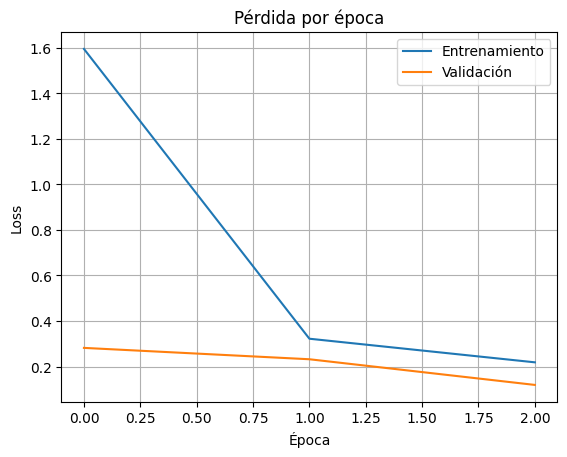

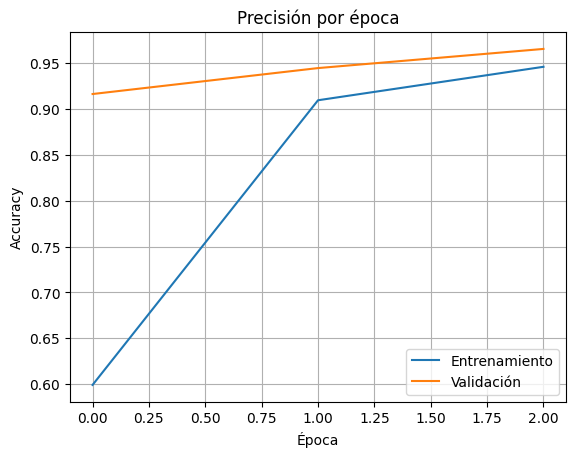

Época [01/30] Pérdida entrenamiento: 1.3308, Accuracy: 0.6688 | Pérdida validación: 0.4216, Accuracy: 0.9040
Modelo guardado. val_loss = 0.4216
Época [02/30] Pérdida entrenamiento: 0.2183, Accuracy: 0.9436 | Pérdida validación: 0.1266, Accuracy: 0.9624
Modelo guardado. val_loss = 0.1266
Criterio de early stopping alcanzado (media_perdida_validacion <= 0.2). Detenemos el entrenamiento.


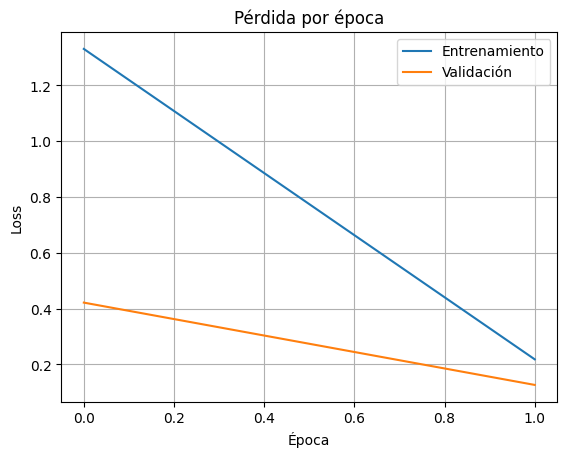

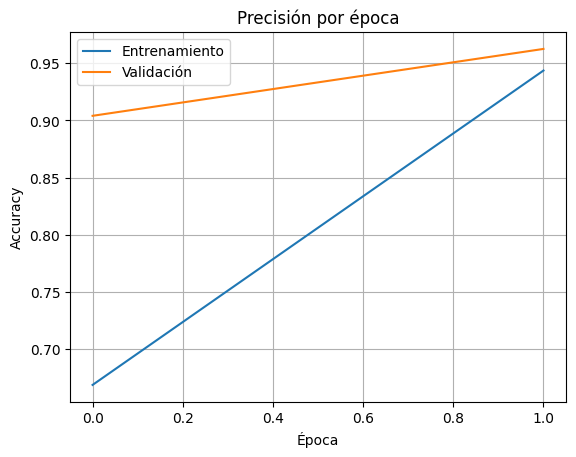

Época [01/30] Pérdida entrenamiento: 1.7571, Accuracy: 0.5509 | Pérdida validación: 0.3490, Accuracy: 0.9008
Modelo guardado. val_loss = 0.3490
Época [02/30] Pérdida entrenamiento: 0.3106, Accuracy: 0.9053 | Pérdida validación: 0.1440, Accuracy: 0.9638
Modelo guardado. val_loss = 0.1440
Criterio de early stopping alcanzado (media_perdida_validacion <= 0.2). Detenemos el entrenamiento.


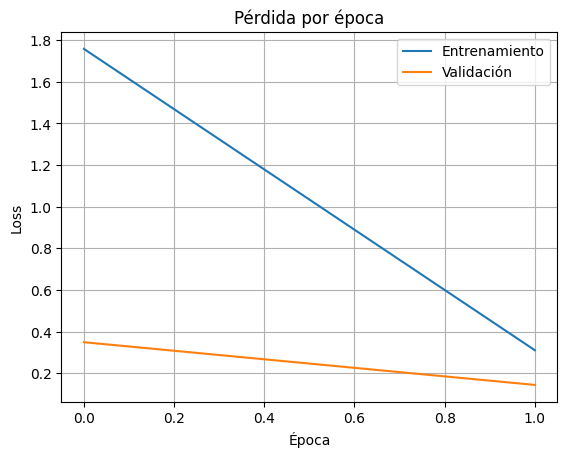

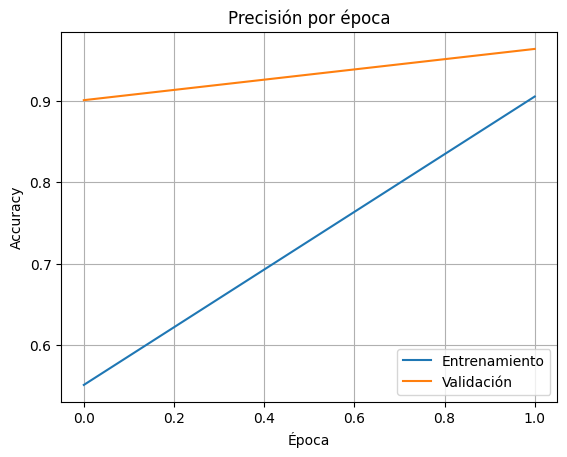

(0.14397105314529723,
 [0.5509444444444445, 0.9052777777777777],
 [0.9007936507936508, 0.9637566137566138],
 [1.757095711882122, 0.310556170825766],
 [0.3490181183448729, 0.14397105314529723])

In [112]:
# Experimento 1: configuración base
modelo_1 = ClasificadorCNN(num_clases, filtros=(32, 64, 128), capa_densa_num_neuronas=256, dropout=0.25)
entrenar_modelo(1, modelo_1, loader_entrenamiento, loader_validacion, num_epocas=30, learning_rate=0.0005, nombre_guardado=FICHERO_MODELO_1, nombre_guardado_txt=FICHERO_INFORMACION_ENTRENAMIENTO_VALIDACION)

# Experimento 2: red más grande, sin dropout
modelo_2 = ClasificadorCNN(num_clases, filtros=(64, 128, 256), capa_densa_num_neuronas=512, dropout=0.001)
entrenar_modelo(2, modelo_2, loader_entrenamiento, loader_validacion, num_epocas=30, learning_rate=0.0005, nombre_guardado=FICHERO_MODELO_2, nombre_guardado_txt=FICHERO_INFORMACION_ENTRENAMIENTO_VALIDACION)

# Experimento 3: igual que base, pero con learning rate más bajo
modelo_3 = ClasificadorCNN(num_clases, filtros=(32, 64, 128), capa_densa_num_neuronas=256, dropout=0.25)
entrenar_modelo(3, modelo_3, loader_entrenamiento, loader_validacion, num_epocas=30, learning_rate=0.0003, nombre_guardado=FICHERO_MODELO_3, nombre_guardado_txt=FICHERO_INFORMACION_ENTRENAMIENTO_VALIDACION)

Una vez que hemos entrenado las tres redes con las diferentes configuraciones de arquitectura, learning rate y doupout, vamos a comparar su rendimiento sobre el conjunto de validación. Como al entrenarlo no guardamos los valores devueltos en una variable al llamar a la funcion y a fin de no repetir siempre el entrenamiento, vamos a evaluar los modelos que hemos guardado en archivosj `.pth` Para ello, vamos a cargar sus pesos entrenados y ejecutar una pasada completa sobre los datos de validación.

Para porder hacer esto hemos definido una función que nos permite cargar un modelo entrenado, aplicarle los pesos almacenados y calcular tanto la perdida como la precisión sobre el `loader_validacion`, manteniendo constantes todos los demás valores. De esta forma, garantizamos que la comparaión entre los modelos es justa y que estamos evaluando su rendimiento de manera consistente.

In [113]:
def evaluar_modelo(ruta_pesos, modelo_base, loader_validacion):
    """Evalúa un modelo previamente entrenado en el conjunto de validación.

    Args:
        ruta_pesos: Ruta del fichero donde se guardaron los pesos del modelo.
        modelo_base: Modelo de red neuronal convolucional (CNN) a evaluar.
        loader_validacion: DataLoader para el conjunto de validación.

    Returns:
        tuple: Pérdida de validación y precisión de validación.
    """

    # Si tenemos una GPU disponible, la usamos para acelerar el proceso
    dispositivo = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Cargamos el modelo y los pesos
    modelo_base.to(dispositivo)
    modelo_base.load_state_dict(torch.load(ruta_pesos))

    # Ponemos el modelo en modo evaluación (desactiva dropout y batch normalization)
    modelo_base.eval()

    # Definimos la función de pérdida (CrossEntropyLoss)
    # y las variables para guardar las estadísticas
    funcion_perdida = nn.CrossEntropyLoss()
    total, correctas, perdida_total = 0, 0, 0.0

    # Iteramos sobre el conjunto de validación
    # y calculamos la pérdida y precisión
    # (no necesitamos calcular los gradientes, por lo que usamos torch.no_grad())
    with torch.no_grad():
        for imagenes, etiquetas in loader_validacion:
            # Pasamos las imágenes y etiquetas a la GPU si está disponible
            # (si no, las dejamos en la CPU)
            imagenes, etiquetas = imagenes.to(dispositivo), etiquetas.to(dispositivo)

            # Pasamos las imágenes por el modelo y calculamos la pérdida
            salidas = modelo_base(imagenes)
            perdida = funcion_perdida(salidas, etiquetas)
            perdida_total += perdida.item()

            # Calculamos las predicciones y la precisión
            # (torch.max devuelve el valor máximo y su índice)
            _, prediccion = torch.max(salidas, 1)

            # Sumamos el número total de imágenes y las predicciones correctas.
            # Comparamos las predicciones con las etiquetas reales para calcular la precisión
            total += etiquetas.size(0)
            correctas += (prediccion == etiquetas).sum().item()

    accuracy_validacion = correctas / total
    perdida_validacion = perdida_total / len(loader_validacion)
    return perdida_validacion, accuracy_validacion

# Definimos los modelos para evaluar (para no tener que volver a ejecutar el codigo de antes)
modelo_1 = ClasificadorCNN(num_clases, filtros=(32, 64, 128), capa_densa_num_neuronas=256, dropout=0.25)
modelo_2 = ClasificadorCNN(num_clases, filtros=(64, 128, 256), capa_densa_num_neuronas=512, dropout=0.001)
modelo_3 = ClasificadorCNN(num_clases, filtros=(32, 64, 128), capa_densa_num_neuronas=256, dropout=0.25)

# Evaluamos los modelos en el conjunto de validación y guardamos los resultados
perdidas_validacion_1, accuracy_validacion_1 = evaluar_modelo(FICHERO_MODELO_1, modelo_1, loader_validacion)
perdidas_validacion_2, accuracy_validacion_2 = evaluar_modelo(FICHERO_MODELO_2, modelo_2, loader_validacion)
perdidas_validacion_3, accuracy_validacion_3 = evaluar_modelo(FICHERO_MODELO_3, modelo_3, loader_validacion)

# Definimos las listas para guardar los resultados finales
# (para poder compararlos entre ellos)
perdidas_finales = [
    perdidas_validacion_1,
    perdidas_validacion_2,
    perdidas_validacion_3
]

accuracies_finales = [
    accuracy_validacion_1,
    accuracy_validacion_2,
    accuracy_validacion_3
]

# Buscamos el índice del modelo con menor pérdida de validación
# (que es el que nos interesa para comparar los resultados)
indice_mejor = perdidas_finales.index(min(perdidas_finales))

print("---------------------------------------------------------------------------------")
print("                               Resultados finales                                ")
print("---------------------------------------------------------------------------------")
print(f"* Modelo 1 - Perdida validación: {perdidas_validacion_1:.4f}, Accuracy validación: {accuracy_validacion_1:.4f}")
print(f"* Modelo 2 - Perdida validación: {perdidas_validacion_2:.4f}, Accuracy validación: {accuracy_validacion_2:.4f}")
print(f"* Modelo 3 - Perdida validación: {perdidas_validacion_3:.4f}, Accuracy validación: {accuracy_validacion_3:.4f}")
print("\n")
print(f"El modelo {indice_mejor + 1} es el mejor con pérdida de validación de {perdidas_finales[indice_mejor]:.4f} y accuracy de {accuracies_finales[indice_mejor]:.4f}.")

---------------------------------------------------------------------------------
                               Resultados finales                                
---------------------------------------------------------------------------------
* Modelo 1 - Perdida validación: 0.1193, Accuracy validación: 0.9656
* Modelo 2 - Perdida validación: 0.1266, Accuracy validación: 0.9624
* Modelo 3 - Perdida validación: 0.1440, Accuracy validación: 0.9638


El modelo 1 es el mejor con pérdida de validación de 0.1193 y accuracy de 0.9656.


Como acabamos de calcular el modelo con el mejor rendimiento, vamos a dibujar su arquitectura y mostrar la información relativa al mismo.

In [114]:
# Cargmamos los pesos de los modelos entrenados para poder usar el mejor modelo
modelo_1 = ClasificadorCNN(num_clases, filtros=(32, 64, 128), capa_densa_num_neuronas=256, dropout=0.25)
modelo_1.load_state_dict(torch.load(FICHERO_MODELO_1))

modelo_2 = ClasificadorCNN(num_clases, filtros=(64, 128, 256), capa_densa_num_neuronas=512, dropout=0.001)
modelo_2.load_state_dict(torch.load(FICHERO_MODELO_2))

modelo_3 = ClasificadorCNN(num_clases, filtros=(32, 64, 128), capa_densa_num_neuronas=256, dropout=0.25)
modelo_3.load_state_dict(torch.load(FICHERO_MODELO_3))

# Guardamos los modelos en una lista para poder acceder a ellos fácilmente
modelos_entrenados = [
    modelo_1,
    modelo_2,
    modelo_3
]

# Seleccionamos el mejor modelo (el que tiene menor pérdida de validación)
mejor_modelo = modelos_entrenados[indice_mejor]

# Hacemos un resumen del modelo para ver su arquitectura
summary(mejor_modelo, input_size=(1, 3, 64, 64))

# Volvemos a establecer el dispositivo para poder usar la GPU si está disponible
# (si no, lo dejamos en la CPU)
dispositivo = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Dibujamos la arquitectura del modelo usando torchview
modelo_dibujo = draw_graph(
    mejor_modelo,
    input_size=(1, 3, 64, 64),
    expand_nested=True,
    graph_name="Arquitectura CNN",
    save_graph=True,
    directory="./output/FandV",
    filename="cnn_modelo",
    device=dispositivo
)


def extraer_capas_para_graphviz(modelo):
    """Extrae las capas del modelo para dibujarlas en Graphviz.

    Args:
        modelo: Modelo de red neuronal convolucional (CNN) a evaluar.

    Returns:
        list: Lista de capas del modelo.
    """
    capas = []

    # Iteramos sobre las capas del modelo y extraemos la información
    for capa in modelo.modelo:
        if isinstance(capa, nn.Conv2d):
            capas.append(("Conv2d", capa.out_channels))
        elif isinstance(capa, nn.Linear):
            capas.append(("Linear", capa.out_features))

    return capas


def dibujar_red_desde_modelo_graphviz(modelo, tamano_entrada=3):
    """Dibuja la arquitectura de un modelo de red neuronal usando Graphviz.

    Args:
        modelo: Modelo de red neuronal convolucional (CNN) a dibujar.
        tamano_entrada:

    Returns:
        dibujo_figura: Objetode  Graphviz que representa la arquitectura del modelo.
    """

    # Inicializamos el objeto Graphviz con formato .png
    dibujo_figura = Digraph(format="png")

    # Configuramos el objeto Graphviz
    # Rankdir='LR' significa que dibujamos de izquierda a derecha
    # nodesep='1' significa que la separación entre nodos es de 1
    # ranksep='3' significa que la separación entre capas es de 3
    dibujo_figura.attr(rankdir='LR', nodesep='1', ranksep='3')

    # Extraemos las capas del modelo para dibujarlas con la función
    # que hemos definido antes
    capas = extraer_capas_para_graphviz(modelo)

    # Definimos los colores para las capas
    colores = ["lightblue", "lightgreen", "yellow", "lightcoral", "orange", "plum", "pink"]

    # Nodos de entrada
    nodos_entrada = [f"X{entrada + 1}" for entrada in range(tamano_entrada)]

    # Para cada nodo de entrada, lo dibujamos como un círculo
    # y lo llenamos de color azul claro
    for nodo in nodos_entrada:
        dibujo_figura.node(nodo, shape="circle", style="filled", fillcolor=colores[0], width="0.8")

    # Conectamos los nodos de entrada con las capas
    anteriores = nodos_entrada

    for indice, (tipo, num_neuronas) in enumerate(capas):
        # Dibujamos cada capa como un círculo y la llenamos de color
        # dependiendo del índice de la capa
        nombre_capa = f"C{indice + 1}"
        nodos_actuales = [f"{nombre_capa}_{neurona + 1}" for neurona in range(min(num_neuronas, 12))]
        color = colores[indice % len(colores)]

        for nodo in nodos_actuales:
            dibujo_figura.node(nodo, shape="circle", style="filled", fillcolor=color, width="0.8")

        # Conectamos los nodos de la capa anterior con los nodos de la capa actual
        # (si la capa anterior tiene más de un nodo, conectamos todos con todos)
        for anterior in anteriores:
            for nodo_actual in nodos_actuales:
                dibujo_figura.edge(anterior, nodo_actual)

        anteriores = nodos_actuales

    # Nodo de salida (número final de clases)
    output_node = "Salida"
    dibujo_figura.node(output_node, shape="circle", style="filled", fillcolor="red", width="1")

    for nodo in anteriores:
        dibujo_figura.edge(nodo, output_node)

    return dibujo_figura


red = dibujar_red_desde_modelo_graphviz(mejor_modelo, tamano_entrada=3)
red.render(filename="red_cnn", directory="./output/FandV", cleanup=True, format="png")


(process:7984): Pango-WARNING **: 20:01:19.399: couldn't load font "Linux libertine Not-Rotated 10", falling back to "Sans Not-Rotated 10", expect ugly output.


'output\\FandV\\red_cnn.png'

Después de mostrar y dibujar la arquitectura del modelo, vamos a hacer las predicciones sobre el conjunto de test y mostrar las imágenes junto con sus etiquetas predichas. Para ello, vamos a cargar el conjunto de test y aplicar la misma transformación que aplicamos al conjunto de validación. Luego, vamos a hacer las predicciones y mostrar las imágenes junto con sus etiquetas predichas.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


---------------------------------------------------------------------------------
                             Información del dataset                             
---------------------------------------------------------------------------------
* Directorio de las pruebas: ./data/FandV/Test


* Número total de imágenes: 3780
* Dimensiones de las imágenes: torch.Size([3, 64, 64])


* Número de batches de prueba: 3780
* Tamaño de cada batch de prueba: 1




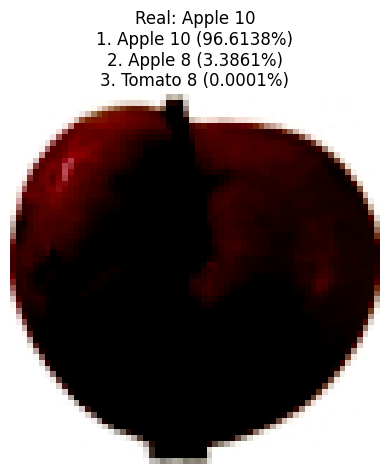

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


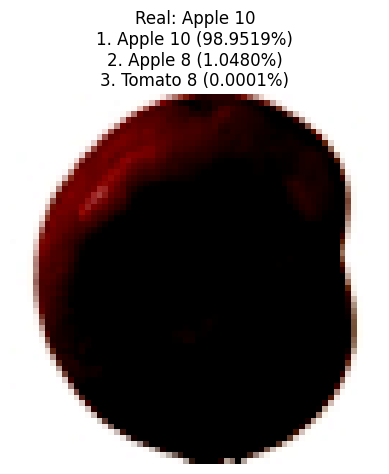

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


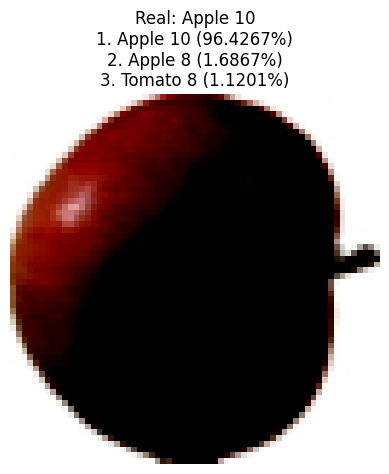

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.96862745..1.0].


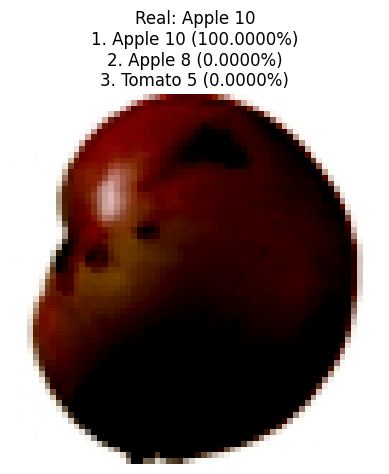

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.96862745..1.0].


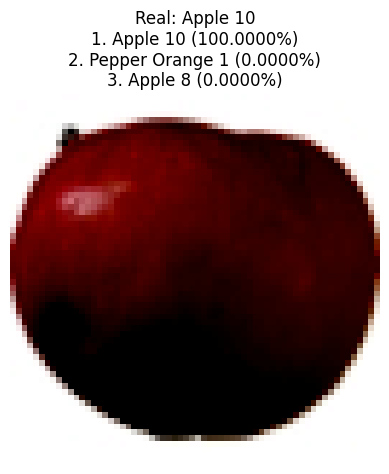

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9764706..1.0].


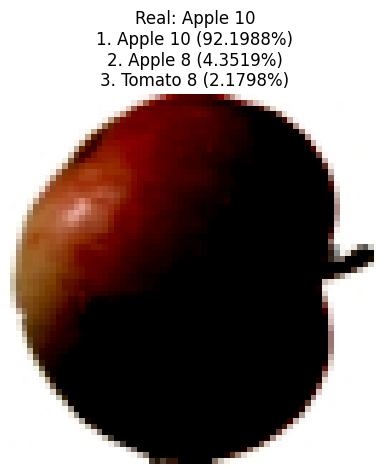

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


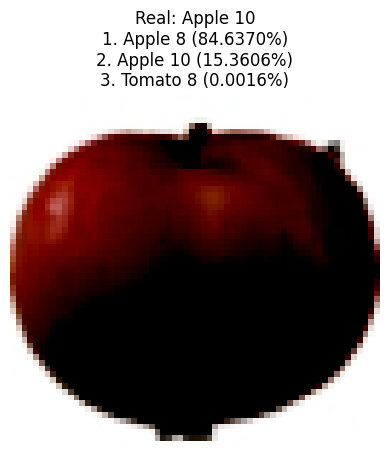

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


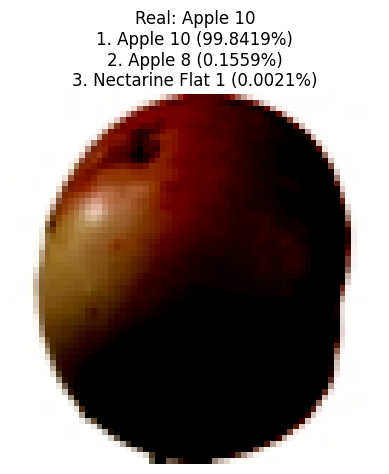

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.99215686..1.0].


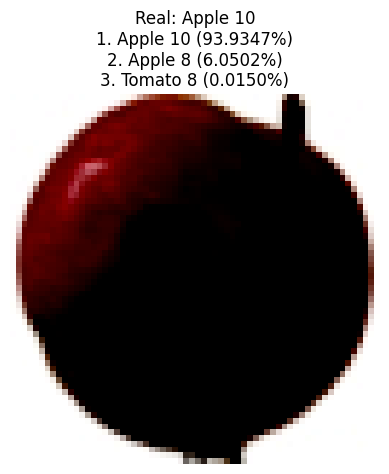

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


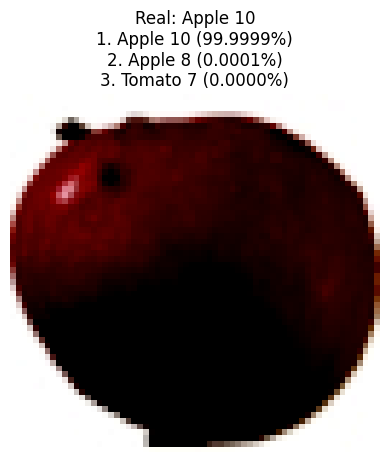

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


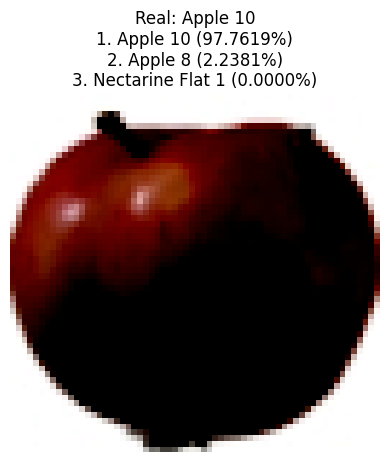

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.99215686..1.0].


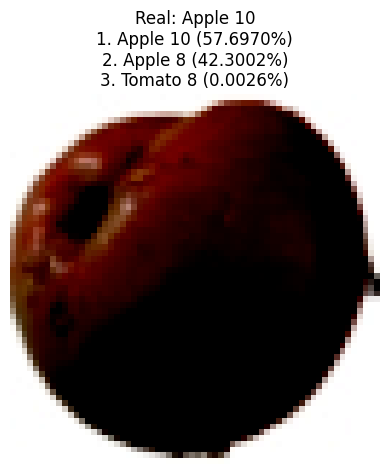

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


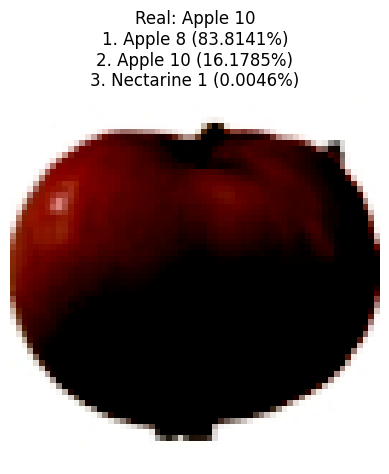

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.8509804..1.0].


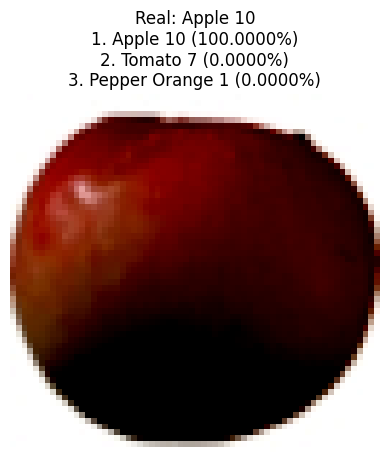

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9764706..1.0].


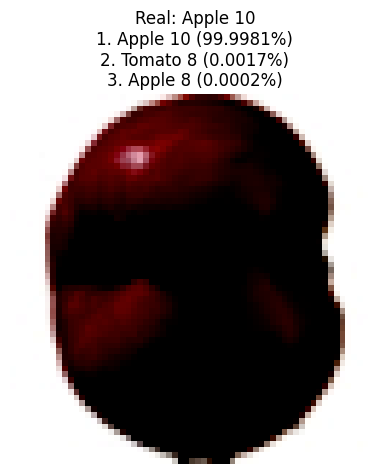

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.85882354..1.0].


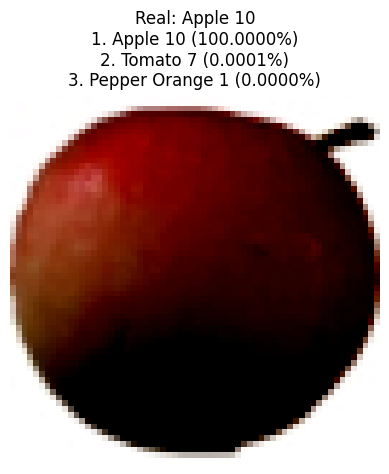

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.96862745..1.0].


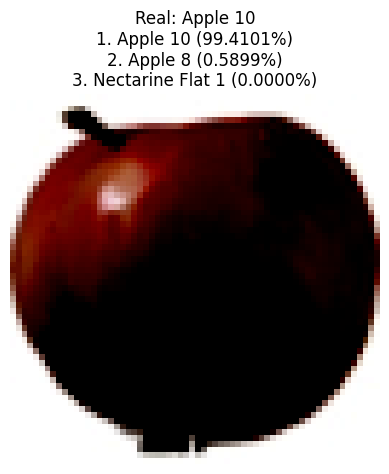

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9764706..1.0].


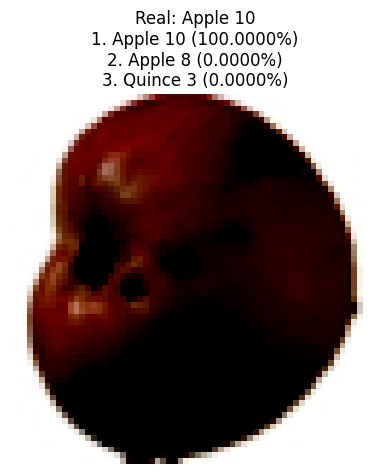

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.85882354..1.0].


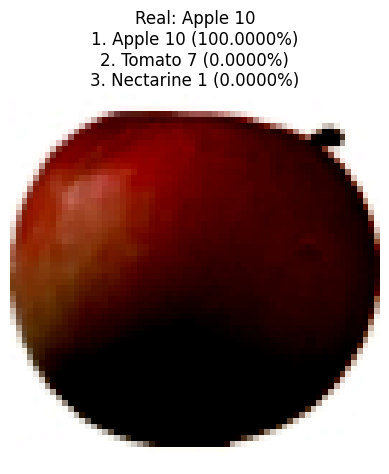

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


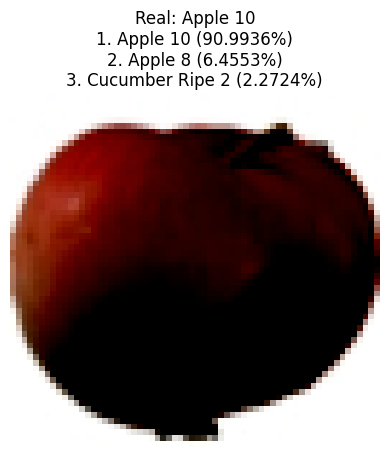

Precisión en las pruebas (top-1): 97.28%
Error en las pruebas: 2.72%


In [115]:
def predecir_top3(modelo, loader_test, clases, mostrar=True, max_muestras=10, ruta_log=FICHERO_PREDICCIONES):
    """Predice las clases de las imágenes en el conjunto de pruebas y muestra los resultados.

    Args:
        modelo: Modelo de red neuronal convolucional (CNN) del que queremos hacer la predicción.
        loader_test: DataLoader para el conjunto de pruebas.
        clases: Lista de clases (etiquetas) del dataset.
        mostrar (bool, optional): Mostrar imágenes con predicciones. Por defecto es True.
        max_muestras (int, optional): Número máximo de imágenes a mostrar (cuantas más, más tiempo tarda). Por defecto es 10.
        ruta_log (str, optional): Ruta del fichero donde se guardarán los resultados de las predicciones. Por defecto es "output/FandV/predicciones_test.txt".
    """

    # Si tenemos una GPU disponible, la usamos para acelerar el proceso
    # (si no, lo dejamos en la CPU)
    dispositivo = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    modelo.to(dispositivo)

    # Ponemos el modelo en modo evaluación (desactiva dropout y batch normalization)
    modelo.eval()

    # Definimos las variables para guardar el número total de imágenes
    # y el número de predicciones correctas
    total = 0
    correctos = 0

    with open(ruta_log, "w", encoding="utf-8") as f:
        # Iteramos sobre el conjunto de pruebas y calculamos las predicciones
        for i, (imagenes, etiquetas) in enumerate(loader_test):
            # Pasamos las imágenes a la GPU si está disponible
            imagen = imagenes.to(dispositivo)

            # Cogemos la etiqueta real (la primera imagen del batch)
            etiqueta_real = etiquetas.item()

            with torch.no_grad():
                # Pasamos la imagen por el modelo y calculamos las probabilidades
                # (usamos softmax para obtener las probabilidades de cada clase)
                salida = modelo(imagen)
                probabilidades = F.softmax(salida, dim=1).cpu().detach().numpy().flatten()

                # Por si acaso hay más probabilidades que clases nos quedamos
                # solo con las que corresponden a las clases
                # (esto puede pasar si el modelo tiene más salidas que clases)
                probabilidades = probabilidades[:len(clases)]

            # Separamos las 3 mejores predicciones
            # Para ello usamos np.argsort para obtener los índices de las 3 mejores predicciones
            # (-3: significa que nos quedamos con las 3 predicciones más altas)
            # (::-1) para invertir el orden (de mayor a menor)
            top3_indices = np.argsort(probabilidades)[-3:][::-1]

            # Obtenemos las etiquetas y probabilidades de las 3 mejores predicciones
            top3_etiquetas = [clases[indice] for indice in top3_indices]

            # Obtenemos las probabilidades de las 3 mejores predicciones
            top3_probabilidades = [probabilidades[indice] for indice in top3_indices]

            prediccion_top1 = top3_indices[0]
            total += 1

            # Si la predicción top-1 es correcta, sumamos 1 a los correctos
            # (comparamos el índice de la predicción con la etiqueta real)
            nombre_predicho = clases[prediccion_top1]
            nombre_real = clases[etiqueta_real]

            if nombre_predicho == nombre_real:
                correctos += 1

            # Mostramos las imagenes con las predicciones
            if mostrar and i < max_muestras:
                img_np = imagenes[0].permute(1, 2, 0).numpy()
                plt.imshow(img_np)
                plt.axis('off')
                plt.title(
                    f"Real: {clases[etiqueta_real]}\n"
                    f"1. {top3_etiquetas[0]} ({top3_probabilidades[0]*100:.4f}%)\n"
                    f"2. {top3_etiquetas[1]} ({top3_probabilidades[1]*100:.4f}%)\n"
                    f"3. {top3_etiquetas[2]} ({top3_probabilidades[2]*100:.4f}%)"
                )
                plt.show()

            # Guardar en .txt
            f.write(f"---\nFruta {i+1}:\n")
            f.write(f"  * Clase real -> {clases[etiqueta_real]}\n")
            f.write(f"  * 1º Predicción -> {top3_etiquetas[0]} ({top3_probabilidades[0]*100:.4f}%)\n")
            f.write(f"  * 2º Predicción -> {top3_etiquetas[1]} ({top3_probabilidades[1]*100:.4f}%)\n")
            f.write(f"  * 3º Predicción -> {top3_etiquetas[2]} ({top3_probabilidades[2]*100:.4f}%)\n")

    accuracy = correctos / total
    error = 1 - accuracy

    with open(ruta_log, "a", encoding="utf-8") as f:
        f.write(f"\n\nPrecisión en las pruebas (top-1): {accuracy:.2%}\n")
        f.write(f"Error en las pruebas: {error:.2%}\n")

    print(f"Precisión en las pruebas (top-1): {accuracy:.2%}")
    print(f"Error en las pruebas: {error:.2%}")

transformacion_pruebas = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])


# Mostramos la información del dataset de prueba
print("---------------------------------------------------------------------------------")
print("                             Información del dataset                             ")
print("---------------------------------------------------------------------------------")
print(f"* Directorio de las pruebas: {DIRECTORIO_PRUEBAS}")
print("\n")
print(f"* Número total de imágenes: {len(dataset_pruebas)}")
print(f"* Dimensiones de las imágenes: {dataset_pruebas[0][0].shape}")
print("\n")
print(f"* Número de batches de prueba: {len(loader_pruebas)}")
print(f"* Tamaño de cada batch de prueba: {loader_pruebas.batch_size}")
print("\n")

predecir_top3(mejor_modelo, loader_pruebas, dataset_sin_transformar.classes, mostrar=True, max_muestras=20)

### Referencias
* [Convolutional neural network - ScienceDirect](https://www.sciencedirect.com/topics/computer-science/convolutional-neural-network).